# Codigo ejemplo de Turbinas Eólicas

Using cpu device
------------------------------
| time/              |       |
|    fps             | 10916 |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 40960 |
------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 2596      |
|    iterations           | 2         |
|    time_elapsed         | 31        |
|    total_timesteps      | 81920     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.09     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 9.36e+16  |
|    n_updates            | 10        |
|    policy_gradient_loss | -4.26e-08 |
|    std                  | 1         |
|    value_loss           | 2.36e+17  |
---------------------------------------
------

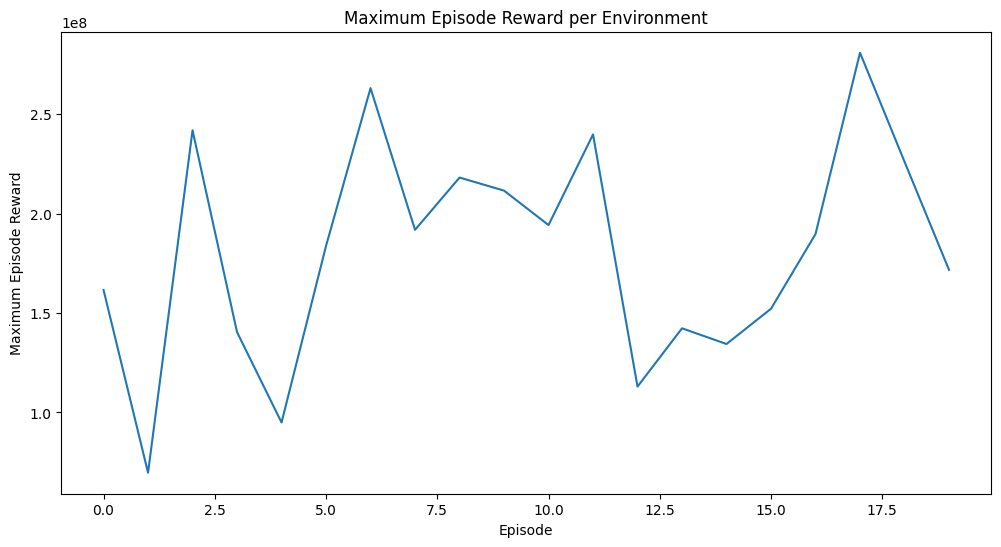

,max_reward,wind_speed,wind_direction,turbine_orientation
0,161554800.0,23.689404,4.655668,"[5.455711364746094, 4.930172920227051, 3.21979..."
1,69677568.0,15.809352,4.251453,"[4.153761386871338, 0.607561469078064, 4.04418..."
2,241857888.0,24.206440,5.424932,"[5.940284729003906, 5.322709560394287, 5.64545..."
3,140351712.0,20.724646,5.547818,"[5.98602294921875, 5.88215446472168, 2.3673884..."
4,94936712.0,18.313984,1.247440,"[3.6316521167755127, 1.2127487659454346, 1.259..."
5,183718528.0,20.853031,1.037543,"[1.2536015510559082, 0.5773685574531555, 1.032..."
6,263056768.0,24.691008,2.186306,"[2.29650616645813, 2.5258848667144775, 2.60958..."
7,191787968.0,24.644068,6.187096,"[0.14474795758724213, 0.1551424264907837, 0.28..."
8,218080208.0,24.040161,3.921700,"[3.945749521255493, 0.3378065526485443, 3.9645..."
9,211520608.0,24.021364,0.201816,"[1.685975193977356, 6.239765167236328, 6.20839..."


In [6]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from IPython.display import display


# Uso DQN
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed


from custom_env.turbinas_env import TurbinasEnv



def make_env(env_id: str, rank: int, seed: int):
    def _init():
        try:
            
            env = gym.make(env_id, render_mode="human")
            env.reset(seed=seed + rank)
            return env
        except Exception as e:
            # Esto imprimirá cualquier error que ocurra dentro del entorno
            print(f"Error al inicializar el entorno: {e}")
            raise e
    set_random_seed(seed)
    return _init


if __name__ == "__main__":
    env_id = 'TurbinasEnv-v0'  # Asegúrate de que este ID coincida con el que registraste

    num_cpu = 20  # Number of processes to use
    # Create the vectorized environment

    seed = np.random.randint(0, 10)


    vec_env = DummyVecEnv([make_env(env_id, i, seed) for i in range(num_cpu)])

    

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)

    model = PPO("MultiInputPolicy", vec_env, verbose=1, n_steps=2048)
    #Para aumentar el numero de iteraciones cambio el valor de total_timesteps
    model.learn(total_timesteps=100_000)

    # Initialize the rewards list for each environment
        
    episode_rewards = [[] for _ in range(num_cpu)]  # List of lists to hold rewards per environment
    num_episodes = [0 for _ in range(num_cpu)]  # Track the number of episodes completed per environment

    episode_vars = []

    # Reemplaza episode_rewards y episode_vars con una estructura que pueda mantener ambas
    episode_data = [{'rewards': [], 'observations': []} for _ in range(num_cpu)]

    obs = vec_env.reset()
    
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)
        
        for i in range(num_cpu):
            wind_speed = obs["wind_speed"][i, 0]  # Accede al elemento del entorno i-ésimo
            wind_direction = obs["wind_direction"][i, 0]  # Accede al elemento del entorno i-ésimo
            turbine_orientations = obs["turbine_orientations"][i, :]  # Accede a la fila entera del entorno i-ésimo
            
            # Guarda las recompensas y las observaciones juntas
            episode_data[i]['rewards'].append(rewards[i])
            episode_data[i]['observations'].append({
                'wind_speed': wind_speed,
                'wind_direction': wind_direction,
                'turbine_orientation': turbine_orientations.tolist()
            })

            if dones[i]:
                num_episodes[i] += 1  # Increment episode count for the environment
                if 'reset' in info[i]:
                    obs = vec_env.reset()

    max_rewards_info = []

    for episode in episode_data:
        max_reward_index = np.argmax(episode['rewards'])
        max_reward = episode['rewards'][max_reward_index]
        max_reward_obs = episode['observations'][max_reward_index]
        
        max_rewards_info.append({
            'max_reward': max_reward,
            'observations': max_reward_obs
        })

    max_rewards = [info['max_reward'] for info in max_rewards_info]


    # And we plot the maximum reward across environments
    plt.figure(figsize=(12, 6))
    plt.plot(max_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Maximum Episode Reward')
    plt.title('Maximum Episode Reward per Environment')
    plt.savefig('reward_plot.png')
    plt.show()

    # Preparar la lista de filas
    filas = []
    for item in max_rewards_info:
        filas.append({
            'max_reward': item['max_reward'],
            'wind_speed': item['observations']['wind_speed'],
            'wind_direction': item['observations']['wind_direction'],
            'turbine_orientation': item['observations']['turbine_orientation'],
        })

    # Convertir en DataFrame
    df = pd.DataFrame(filas)

    display(df)


